In [1]:
import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch 

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)


with open('results/betas_ridge_individual.pkl', 'rb') as f:
    betas = pickle.load(f)

with open('results/rmse_ridge_individual.pkl', 'rb') as f:
    rmse = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)


import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))

# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble

x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    x_predictor[m] = {}
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
       
        x_predictor[m][i] = dic_processed_ssp585[m][i][131:164,:,:]
        nans_idx = np.where(np.isnan(x_predictor[m][i][0,:,:].ravel()))[0]

/tmp/ipykernel_15163/3309999009.py:46: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
/tmp/ipykernel_15163/3309999009.py:48: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])


In [2]:
# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

lon_size = lon.shape[0]
lat_size = lat.shape[0]

In [3]:
best_rmse = {}
for idx_m, m in enumerate(rmse.keys()):
    best_rmse[m] = {}
    lambda_range = np.array(list(rmse[m].keys()))
    for idx_l, l in enumerate(rmse[m].keys()):
        best_rmse[m][l] = np.array(list(rmse[m][l].values())).mean()

In [4]:
best_lambda = {}
for idx_m, m in enumerate(rmse.keys()):
    best_lambda[m] = lambda_range[np.array(list(best_rmse[m].values())).argmin()]

In [5]:
best_betas = {}
for idx_m, m in enumerate(betas.keys()):
    best_betas[m] = np.mean(np.array(list(betas[m][best_lambda[m]].values())),axis=0)

In [6]:
best_betas_array = np.zeros((len(list(betas.keys())),lon_size*lat_size))
for idx_m, m in enumerate(list(betas.keys())):
    best_betas_array[idx_m, :] = best_betas[m]

# Beta analysis

In [7]:
# run with PCA with pytorch
best_betas_torch = torch.from_numpy(best_betas_array)
U,S,V = torch.pca_lowrank(best_betas_torch, q=6, center=False, niter=10)
proj_first_comp = torch.matmul(best_betas_torch, V[:, :6])

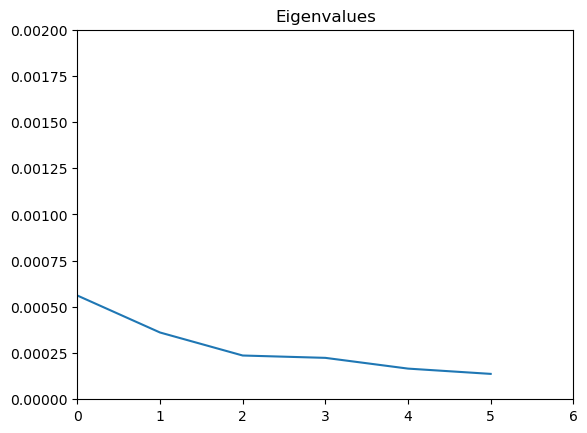

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(S**2/25)
plt.ylim((0.0,0.002))
plt.xlim((0.0,6))
plt.title('Eigenvalues')
plt.show()

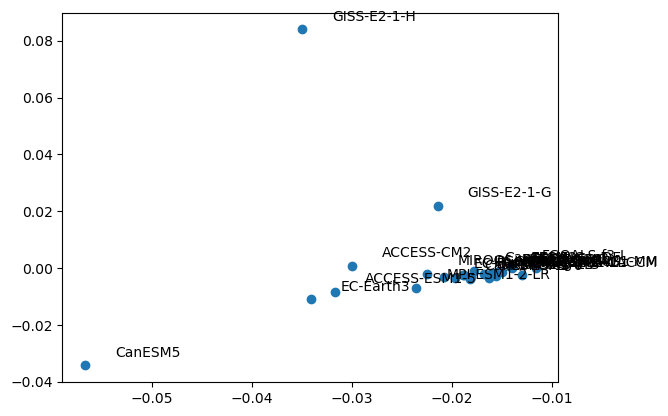

In [9]:
comp_x = 0
comp_y = 1

fig, ax = plt.subplots()
ax.scatter(proj_first_comp[:,comp_x],proj_first_comp[:,comp_y])

for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
    ax.annotate(m, (proj_first_comp[idx_m,comp_x]+.003, proj_first_comp[idx_m,comp_y]+.003))

plt.show()

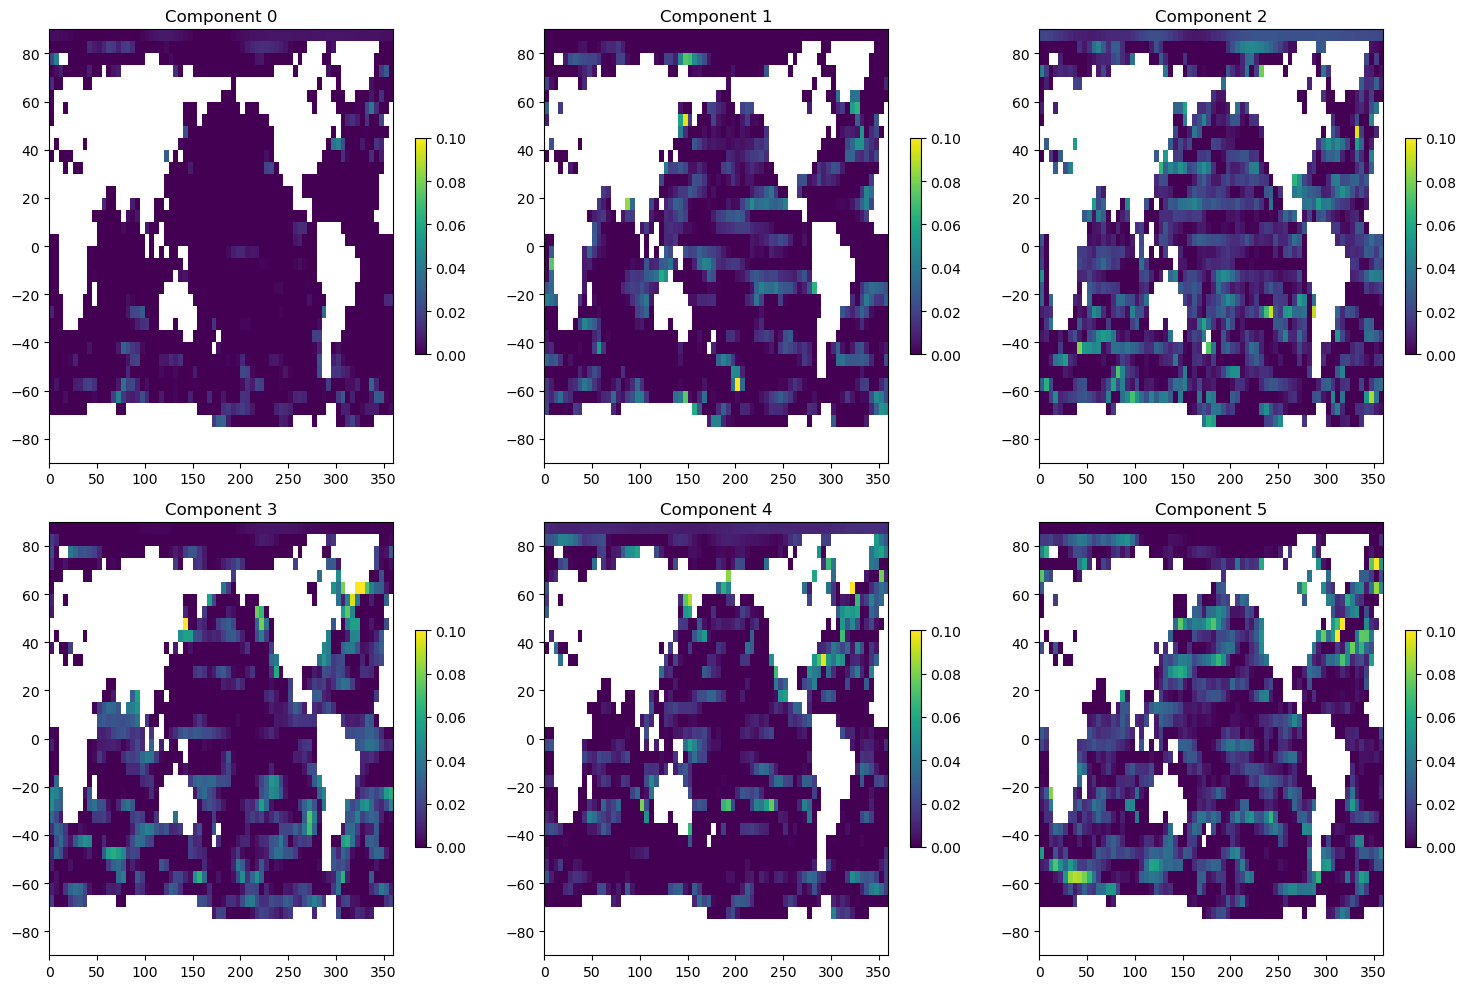

In [10]:
# plot the beta map of each mode
fig, axs = plt.subplots(2,3, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for k in range(6):
        
    beta_tmp = V[:,k].detach().clone()
    beta_tmp[nans_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(lat_size,lon_size)

    axs[k].set_title('Component '+ str(k))
    im0 = axs[k].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.1)

    plt.colorbar(im0, ax=axs[k], shrink=0.5)

fig.tight_layout()
plt.show()

In [11]:
# hierarchical clustering 

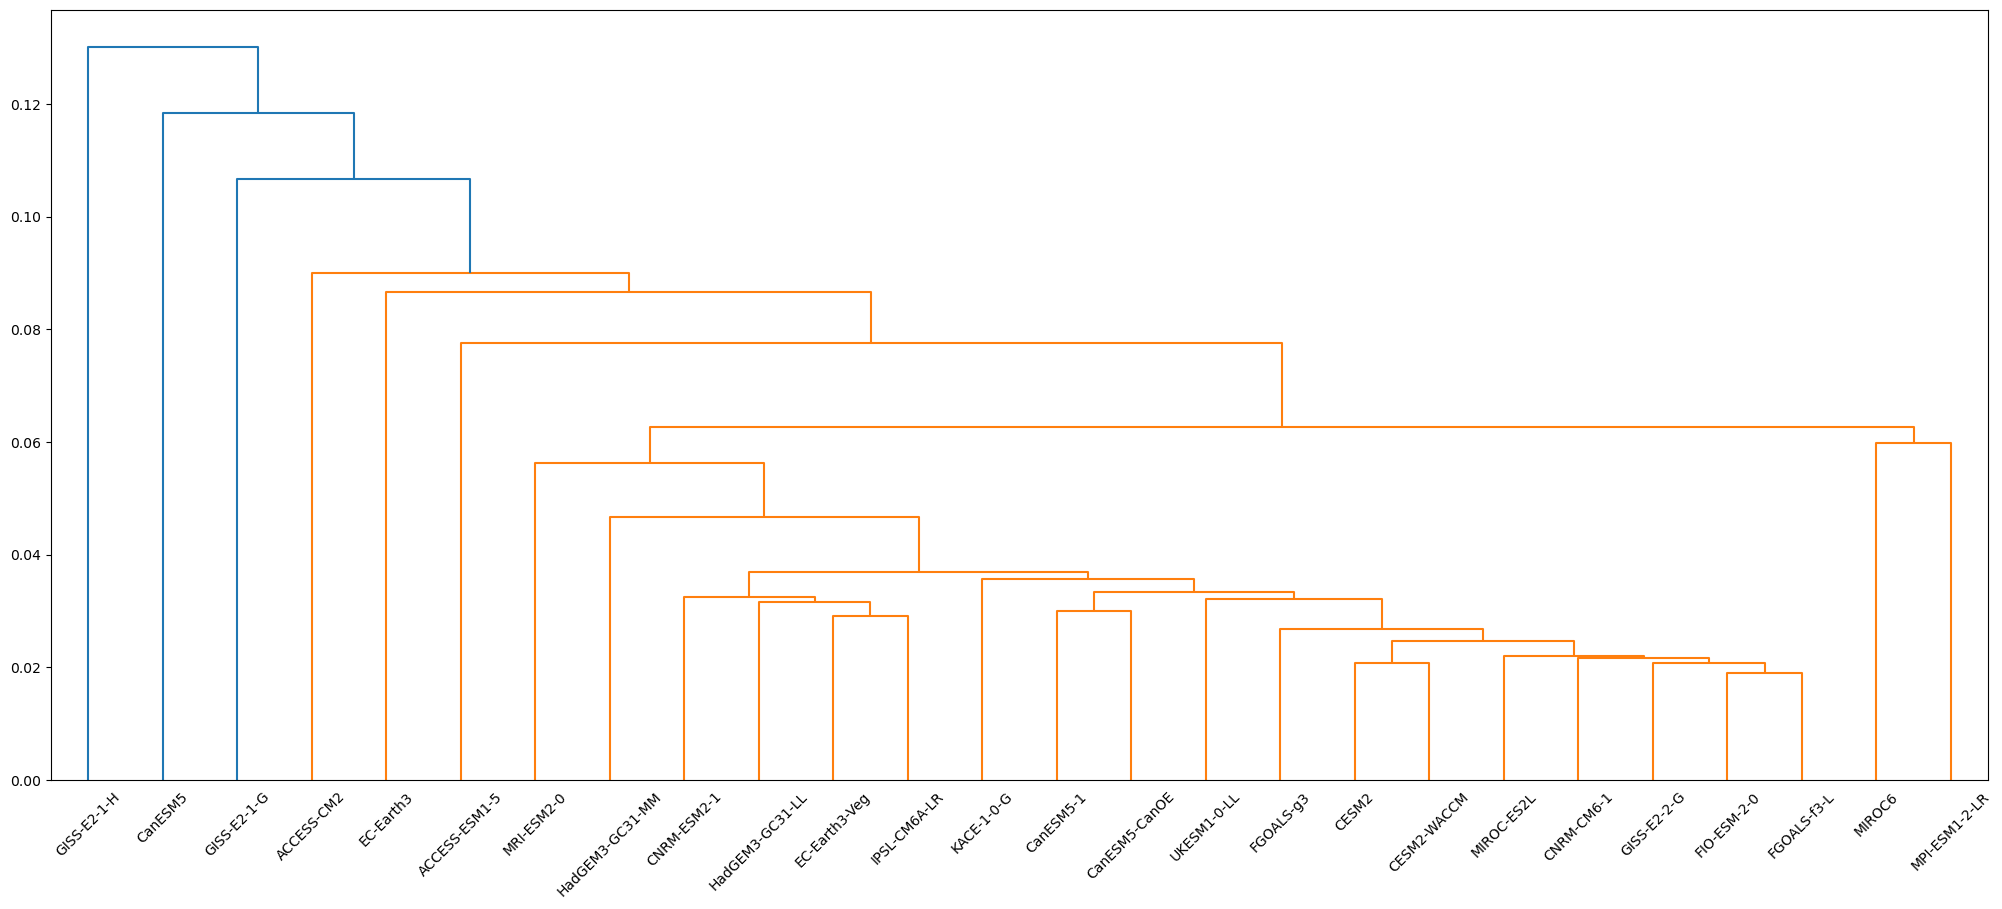

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

models = list(dic_reduced_ssp585.keys())
Z1 = linkage(best_betas_torch.detach().numpy(), 'ward')
leaves_tmp = leaves_list(Z1)

labels_tmp =  [models[int(i)] for i in leaves_tmp] 


fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z1,labels = models)

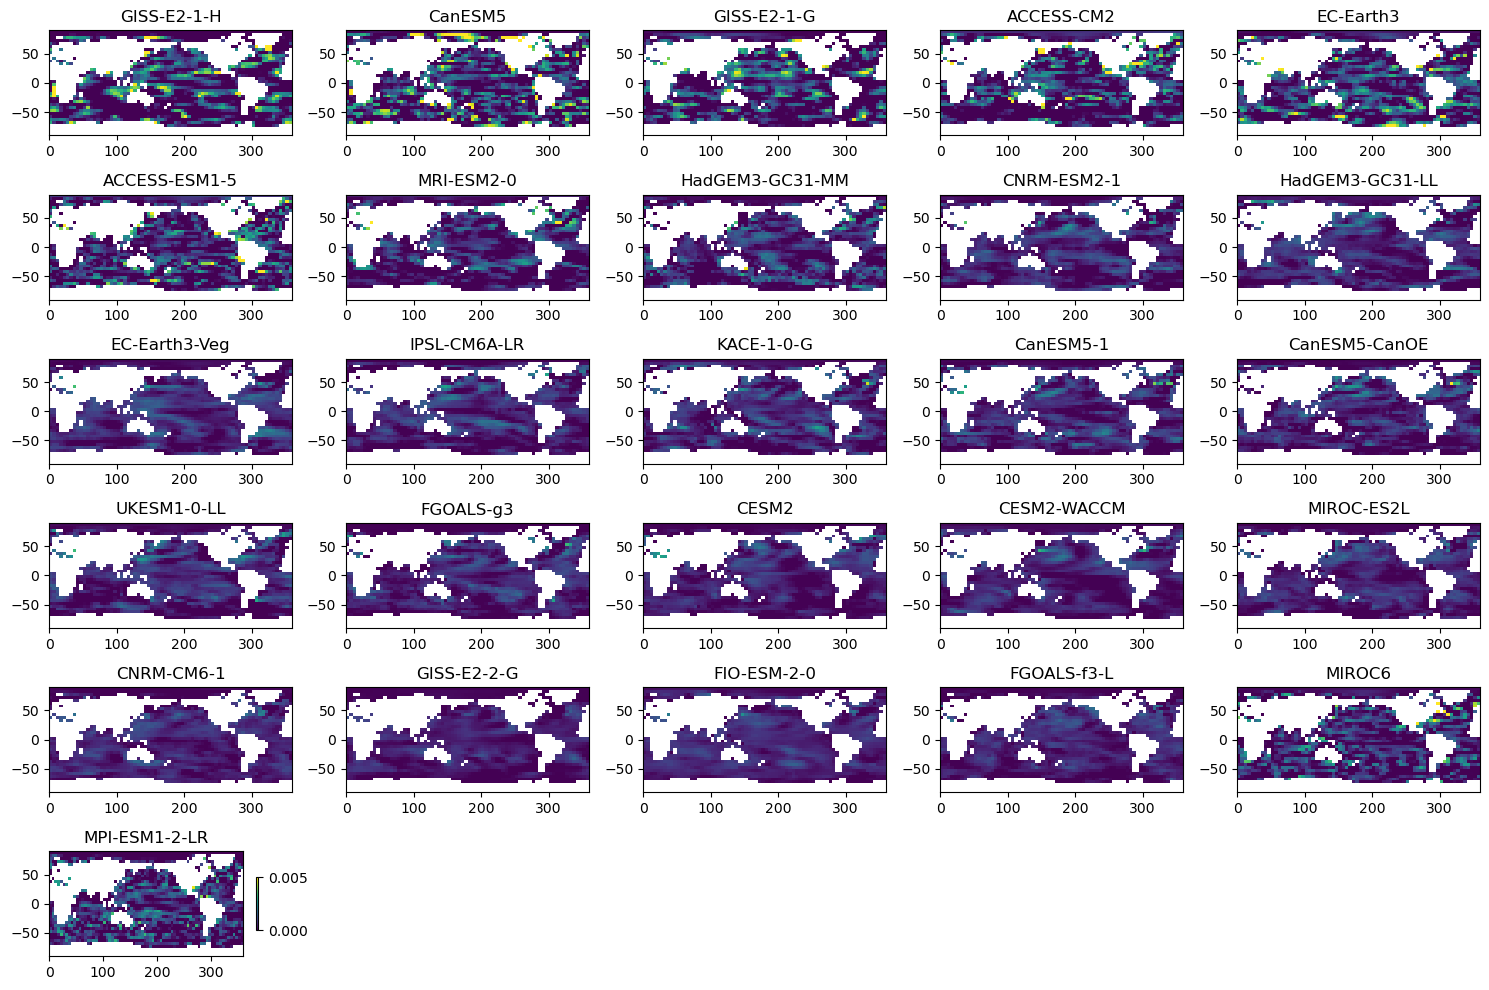

In [13]:
# plot the beta maps in the leaf-based ordering
fig, axs = plt.subplots(6,5, figsize=(15,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2.0, wspace=1.0)

axs = axs.ravel()
    
for idx,i in enumerate(dn['leaves']):

    m = models[int(i)] 
    beta_tmp = best_betas_torch[int(i),:].detach().clone()
    beta_tmp[nans_idx] = float('nan')
    beta_tmp = beta_tmp.detach().numpy().reshape(lat_size,lon_size)

    axs[idx].set_title(m)
    im0 = axs[idx].pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.005)

plt.colorbar(im0, ax=axs[idx], shrink=0.5)

for i in range(len(dic_reduced_ssp585.keys()),30):
    fig.delaxes(axs[i])

fig.tight_layout()
plt.show()